<a href="https://colab.research.google.com/github/TheRoberto2512/DeepBrainMRI/blob/main/Classificatore%20II%20(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**FACE MORPHING DETECTION: CLASSIFICATORE II**</font>
</br><font size=3>*Roberto A. Usai, Davide Senette, Chiara Scalas*</font>



<p align="justify">Questo notebook si propone di sviluppare un classificatore basato su <b>reti neurali convoluzionali (CNN)</b>, utilizzando <b>EfficientNetV2-S</b> come architettura di base. Il focus è implementare e affinare questa struttura tramite tecniche di fine-tuning, con l'obiettivo di ottimizzare il riconoscimento e la distinzione tra immagini di visi autentici e quelle manipolate tramite tecniche di morphing. <br><br>
In aggiunta, viene implementata la tecnica del <b>Grad-CAM</b> (<b>Grad</b>ient-weighted <b>Clas</b>s <b>A</b>ctivation <b>M</b>apping) per generare delle heatmaps che visualizzino le aree dell'immagine che influenzano maggiormente le decisioni del modello.</p>

**Indice:**
*   [Import librerie e impostazioni](#1)
*   [Dataset](#2)
*   [Classificatore](#3)
*   [XAI: rendere il modello spiegabile](#4)
*   [Tuning](#5)
*   [Test Dataset Esterni](#6)

<a name="1"></a>
# **Import librerie e impostazioni**

In [ ]:
!pip install -q -U keras-tuner
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.metrics import roc_curve, auc
from tf_keras_vis.gradcam import Gradcam
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.cm as cm
import keras_tuner as kt
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import numpy as np
import warnings
import random
import shutil
import json
import cv2
import sys
import os

Prima importiamo le librerie, poi montiamo Google Drive per poter accedere facilmente agli altri file.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Path della cartella del progetto su Google Drive:

#@markdown <font color="#ed7d31"><b>Necessario per poter accedere agli altri file</b>!</font>
#@markdown <br>Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:
DRIVE_PATH = "MAD Project" #@param {type:"string"}

DRIVE_PATH = '/content/drive/MyDrive/' + DRIVE_PATH

WEIGHTS_PATH = DRIVE_PATH + '/Weights/'

Carichiamo le funzioni comuni presenti nel file python shared_utilities

In [ ]:
sys.path.append(DRIVE_PATH)                       # ci permetterà di importare le funzioni presenti in altri file
from shared_utilities import download_dataset, move_files, split_dataset, get_img_array

Scarichiamo dal file .json gli ID necessari per il download del dataset e del csv.

In [ ]:
with open(DRIVE_PATH + '/settings.json', 'r') as file:
  config = json.load(file)

DATASET_ID = config['DATASET_ID']

In [ ]:
#@title Caricamento di un dataset custom

#@markdown Inserire l'ID del dataset custom. Qualora si volesse usare l'originale, lasciare vuoto.
DATASET_CUSTOM = "" #@param {type:"string"}

if DATASET_CUSTOM != "":
  DATASET_ID = DATASET_CUSTOM

In [ ]:
#@title Impostazioni del Notebook

#@markdown Seme per le funzioni randomiche del notebook:
SEED = 2407 #@param {type:"integer"}

random.seed(SEED)

np.set_printoptions(suppress=True) # NumPy non utilizzerà la notazione scientifica per piccoli numeri, rendendo l'output più leggibile.

warnings.filterwarnings("ignore", category=UserWarning, module="PIL.Image")

<a name="2"></a>
# **Dataset**


## Download

In [ ]:
#@title Impostazioni download

#@markdown Nome del zip dataset post download:
DATASET_NAME = 'AMSL_dataset.zip' #@param {type:"string"}

download_dataset(DATASET_ID, DATASET_NAME, msg=True)

Dopo aver scaricato il dataset lo manipoliamo in modo da unzipparlo, creare le directory per gli split e infine eliminare i file txt e la cartella sample_data creata automaticamente da Colab.

In [ ]:
%%capture
# evita il fastidioso output a video

! unzip "{DATASET_NAME}"                                  # unzippa il file zip
! rm /content/AMSL/*.txt                                  # elimina i file txt
! rm -r /content/sample_data                              # elimina la cartella di default di Colab

if DATASET_CUSTOM == "":                                  # se il dataset è l'originale
  ! mv /content/AMSL/neutral/* /content/AMSL/smiling      # sposta i file della cartella neutral in smiling
  ! mv /content/AMSL/smiling /content/AMSL/bona_fide      # rinomina smiling in bona_fide
  ! rmdir AMSL/neutral                                    # rimuove la cartella neutral (ormai vuota)

## Split

In [ ]:
#@title Parametri dello split
#@markdown Percentuale di split per il test set:
TEST = 20 #@param  {type:"integer"}

#@markdown Percentuale di split per il validation set:
VAL = 20 #@param  {type:"integer"}

path_dataset = '/content/AMSL'

bona_fide_count = len(os.listdir(os.path.join(path_dataset,'bona_fide')))
morphed_count = len(os.listdir(os.path.join(path_dataset,'morphed')))

# path delle cartelle su Colab
test = '/content/Dataset/test/'
val = '/content/Dataset/val/'
train = '/content/Dataset/train/'

split_dataset(path_dataset=path_dataset, train=train, val=val, test=test, bona_fide_count=bona_fide_count, morphed_count=morphed_count, VAL=VAL, TEST=TEST)

In [ ]:
print("Immagini di test:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/test/bona_fide')), len(os.listdir('/content/Dataset/test/morphed'))) )

print("Immagini di train:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/train/bona_fide')), len(os.listdir('/content/Dataset/train/morphed'))) )

print("Immagini di val:\n-Bona Fide:\t%d\n-Morphed:\t%d\n" % (len(os.listdir('/content/Dataset/val/bona_fide')), len(os.listdir('/content/Dataset/val/morphed'))) )

Immagini di test:
-Bona Fide:	245
-Morphed:	265

Immagini di train:
-Bona Fide:	734
-Morphed:	796

Immagini di val:
-Bona Fide:	245
-Morphed:	265



## Caricamento

In [ ]:
#@title Parametri del dataset

#@markdown Dimensione del batch di addestramento:
BATCH_SIZE = 32 #@param {type:"integer"}

# estrae automaticamente le dimensioni delle immagini
folder_path = '/content/Dataset/test/bona_fide' ; image_files = [f for f in os.listdir(folder_path)]

if image_files:
  with Image.open(os.path.join(folder_path, image_files[0])) as img: # carica la prima immagine per ottenere le dimensioni
    width, height = img.size
    IMAGE_SIZE = (width, height)
    IMAGE_WIDTH, IMAGE_HEIGHT = width, height
    IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Dataset/train',
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    seed = SEED,
    shuffle = True,
)

val_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Dataset/val',
    labels='inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    seed = SEED,
    shuffle = True,
)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/Dataset/test',
    labels = 'inferred',
    label_mode = 'binary',
    color_mode = 'rgb',
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    seed = SEED,
    shuffle = True,
)

class_names = train_data.class_names

Found 1530 files belonging to 2 classes.
Found 510 files belonging to 2 classes.
Found 510 files belonging to 2 classes.


<a name="3"></a>
# **Classificatore**

## Caricamento e costruzione del modello

Per prima cosa importiamo il modello pre-addestrato dalle applications di Keras e gli carichiamo i pesi calcolati durante l'addestramento su ImageNet. Ci assicuriamo di non includere i livelli dense di classificazione perché dovremo collegare quelli ad hoc per il nostro task.

In [ ]:
conv_base = tf.keras.applications.EfficientNetV2S(
    weights="imagenet",
    include_top=False,  # include_top serve per non includere i layer densamente connessi di classificazione
    input_shape=IMAGE_SHAPE,
    pooling = 'max', # più adatto al nostro tipo di problema, per prendere le caratteristiche più importanti dell'input
    include_preprocessing=True
)

82420632/82420632 [==============================] - 3s 0us/step


Di default tutti i pesi addestrabili sono "scongelati", quindi i loro valori verranno aggiornati durante l'addestramento. Visto che l'intenzione è quella di eseguire del Fine Tuning, congeliamo tutti i livelli tranne gli ultimi, in modo che possano specializzarsi insieme ai livelli Dense.

In [ ]:
for layer in conv_base.layers[:-49]:
 layer.trainable = False

Costruiamo il modello inserendo gli strati di classificazione utili al nostro task

In [ ]:
inputs = tf.keras.Input(shape=IMAGE_SHAPE)                                       # la shape è stata definita in precedenza

x = conv_base(inputs)                                                            # estrazione delle feature maps dall'EfficientNetV2S

x = tf.keras.layers.Flatten(name="Flatten1")(x)                                  # vettorializziamo perché i Dense manipolano solo tensori a una dimensione
x = tf.keras.layers.Dropout(rate=0.25, name="DropOut1")(x)
x = tf.keras.layers.Dense(128, activation='relu', name="Dense1")(x)
x = tf.keras.layers.Dropout(rate=0.25, name="DropOut2")(x)

output = tf.keras.layers.Dense(1, activation='sigmoid', name="Dense2")(x)        # layer di output

model = tf.keras.Model(inputs, output)                                           # crea il modello

metrics = [
    'accuracy',                               # Accuratezza, per valutare  il numero di predizioni corrette
    tf.keras.metrics.Precision(),             # Precisione, per valutare il numero di falsi positivi
    tf.keras.metrics.Recall(),                # Richiamo, per valutare il numero di falsi negativi
    tf.keras.metrics.F1Score(threshold=0.5)   # F1-Score, media armonica tra precisione e richiamo
]

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=metrics)    # compila il modello

## Alternativa all'addestramento: caricamento dei pesi

Inseriamo una copia del nostro modello nella runtime di colab

In [ ]:
shutil.copy('/content/drive/MyDrive/MAD Project/Models/EfficientNetV2SFT.keras', '/content/EfficientNetV2SFT.keras')

'/content/EfficientNetV2SFT.keras'

Carichiamo il modello

In [ ]:
model = tf.keras.models.load_model("/content/EfficientNetV2SFT.keras")

## Addestramento

In [ ]:
#@title Settaggi dell'addestramento
#@markdown Epoche per l'addestramento del modello:
EPOCHS = 15 #@param  {type:"integer"}

#@markdown Pazienza dell'early stopping:
PATIENCE = 2 #@param  {type:"integer"}

#@markdown Epoca di partenza dell'early stopping:
START = 10 #@param  {type:"integer"}

Definiamo le callbacks per salvare i milgiori pesi del modello durante l'addestramento

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath="EfficientNetV2SFT.keras", save_best_only=True, monitor="val_loss"),  # salviamo i pesi dell'epoca con la val_loss minore
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, start_from_epoch=START)
]

Addestramento del modello

In [ ]:
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, callbacks=callbacks)

Epoch 1/15
48/48 [==============================] - 43s 385ms/step - loss: 0.6556 - accuracy: 0.8166 - precision: 0.8207 - recall: 0.8279 - f1_score: 0.8243 - val_loss: 0.1071 - val_accuracy: 0.9646 - val_precision: 0.9591 - val_recall: 0.9736 - val_f1_score: 0.9663
Epoch 2/15
48/48 [==============================] - 11s 237ms/step - loss: 0.1233 - accuracy: 0.9550 - precision: 0.9516 - recall: 0.9623 - f1_score: 0.9569 - val_loss: 0.0958 - val_accuracy: 0.9745 - val_precision: 0.9565 - val_recall: 0.9962 - val_f1_score: 0.9760
Epoch 3/15
48/48 [==============================] - 12s 249ms/step - loss: 0.0720 - accuracy: 0.9752 - precision: 0.9761 - recall: 0.9761 - f1_score: 0.9761 - val_loss: 0.0562 - val_accuracy: 0.9784 - val_precision: 0.9635 - val_recall: 0.9962 - val_f1_score: 0.9796
Epoch 4/15
48/48 [==============================] - 11s 234ms/step - loss: 0.0765 - accuracy: 0.9798 - precision: 0.9799 - recall: 0.9812 - f1_score: 0.9805 - val_loss: 0.0328 - val_accuracy: 0.9882 

Per ricaricare i pesi che hanno performato meglio durante l'addestramento:

In [ ]:
model = tf.keras.models.load_model("EfficientNetV2SFT.keras")

## Salvataggio del modello su Google Drive

In [ ]:
shutil.copy('/content/EfficientNetV2SFT.keras', '/content/drive/MyDrive/MAD Project/Models/EfficientNetV2SFT.keras')

## Test e valutazione delle performance

Per valutare le performance del modello:

In [ ]:
test_loss, test_accuracy, test_precision, test_recall, test_f1 = model.evaluate(test_data)
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1-score: {np.mean(test_f1)}")

16/16 [==============================] - 121s 7s/step - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000
Loss: 0.001233945251442492
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [ ]:
# estrae immagini ed etichette per tutte le immagini di test
test_images, test_labels = [], []

for images, labels in test_data:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# prevedere le etichette
predictions = model.predict(test_images)
predicted_labels = (predictions > 0.5).astype("int32").flatten()

16/16 [==============================] - 110s 7s/step


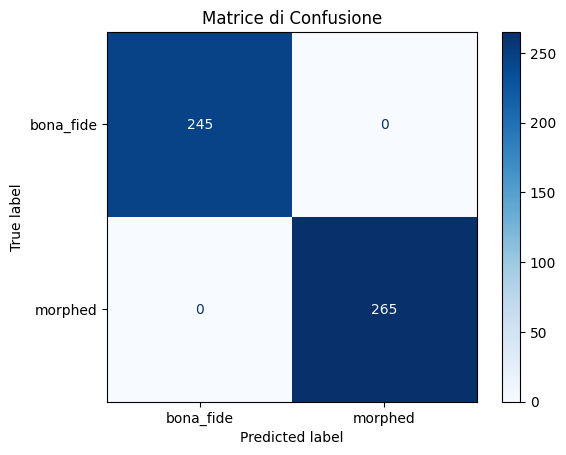

In [ ]:
conf_mat = confusion_matrix(test_labels, predicted_labels) # calcola la matrice di confusione

class_labels = ['bona_fide', 'morphed'] # definisce le etichette delle classi

# visualizzare la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix= conf_mat, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.show()

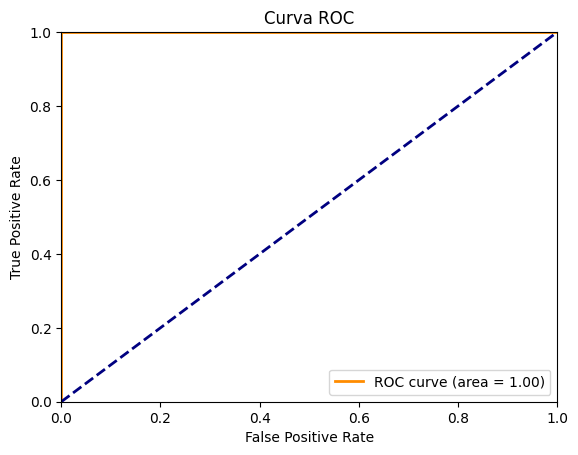

In [ ]:
# calcola la curva ROC e l'area sottesa alla curva
fpr, tpr, _ = roc_curve(test_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# visualizza la curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

<a name="4"></a>
# **XAI: rendere il modello spiegabile**

Nel seguente codice andiamo ad implementare una tecnica di trasparenza algoritmica, in particolare Grad-CAM. Questa tecnica permette di visualizzare quali parti di un'immagine influenzano maggiormente le decisioni di un modello di deep learning, generando mappe di calore che evidenziano le regioni critiche per le predizioni del modello. Questo rende il processo decisionale del modello più interpretabile e comprensibile.

In [ ]:
def create_CAM_XAI_images(classifier_model, img_paths):
    if len(img_paths) < 2 or len(img_paths) > 2:
        raise ValueError("Numero di immagini passate non compatibile")

    # Inizializza un dizionario per memorizzare le immagini CAM per ogni classe
    class_images_cam = {}

    # Estrae il modello EfficientNet dal modello principale
    model = classifier_model.get_layer("efficientnetv2-s")
    # Definisce l'ultimo livello convolutivo di efficient net
    last_conv_layer_name = "top_activation"

    # Crea l'oggetto Gradcam utilizzando il modello specificato
    gradcam = Gradcam(model, clone=True)

    # Itera sui percorsi delle immagini
    for img_path in img_paths:
        # Estrae il nome della classe dal percorso dell'immagine
        class_name = os.path.basename(os.path.dirname(img_path))

        # estraiamo l'array dell'immagine
        img_array = get_img_array(img_path, target_size=IMAGE_SHAPE)

        # Fa una predizione con il modello
        predictions = classifier_model.predict(img_array)
        label = np.argmax(predictions, axis=1)[0]

        # Calcola la confidenza del modello sull'immagine specifica
        confidence = (1 - predictions[0][0]) * 100 if predictions[0][0] < 0.5 else predictions[0][0] * 100

        # Crea il CategoricalScore per il GradCAM
        score = CategoricalScore([label])

        # Genera la heatmap con GradCAM utilizzando l'ultimo strato convoluzionale specificato
        cam = gradcam(score, img_array, penultimate_layer=last_conv_layer_name)

        # Memorizza il percorso dell'immagine, la CAM generata e la confidenza nel dizionario
        if class_name not in class_images_cam:
            class_images_cam[class_name] = []
        class_images_cam[class_name].append((img_path, cam[0], confidence))

    return class_images_cam

In [ ]:
# Funzione per plottare le immagini con CAM
def plot_CAM_image(class_images_cam):
    ncols = len(class_images_cam)
    fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 7))

    # Visualizza le immagini normali
    for i, (class_name, cam_info_list) in enumerate(class_images_cam.items()):
        img_path, cam, confidence = cam_info_list[0]  # Assume che ci sia solo un'immagine per classe per ora
        img = tf.keras.utils.load_img(img_path)  # Carica l'immagine
        ax[0][i].imshow(img)  # Mostra l'immagine
        ax[0][i].set_title(class_name)
        ax[0][i].axis("off")

    # Visualizza le immagini con CAM
    for i, (class_name, cam_info_list) in enumerate(class_images_cam.items()):
        img_path, cam, confidence = cam_info_list[0]  # Assume che ci sia solo un'immagine per classe per ora
        img = cv2.imread(img_path)  # Carica l'immagine
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converti l'immagine in RGB per matplotlib

        ax[1][i].imshow(img)  # Mostra l'immagine originale
        heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)  # Crea la mappa di calore
        ax[1][i].imshow(heatmap, cmap='jet', alpha=0.6)  # Sovrappone la mappa di calore
        ax[1][i].set_title(f"{class_name} ({confidence:.2f}%)")  # Imposta il titolo con la confidenza
        ax[1][i].axis("off")

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 55ms/step


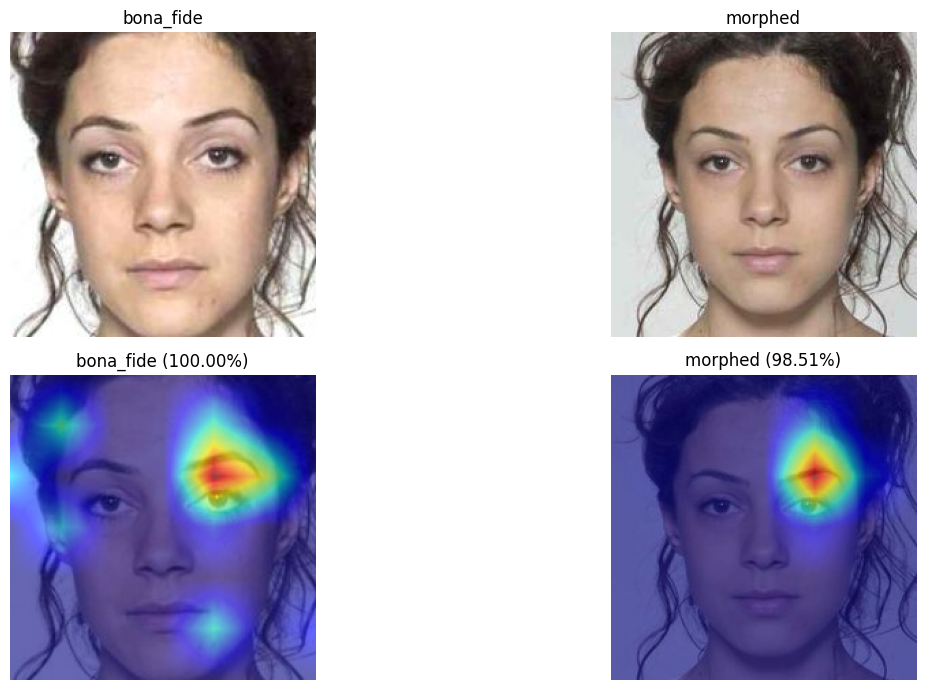

In [ ]:
image_paths = ["/content/Dataset/test/bona_fide/001_8.jpg","/content/Dataset/test/morphed/001_03_007_03_alpha0.5_combined_morph_q33.jpg"]
images = create_CAM_XAI_images(model, image_paths)
plot_CAM_image(images)

<a name="5"></a>
# **Tuning**

In questa sezione di codice implementiamo il tuning degli iperparametri del nostro modello, sia mantenendo i pesi del convolutivo congelati che scongelandoli. In questo modo, determiniamo anche il numero ottimale di layer convolutivi da scongelare di EfficientNet.

In [ ]:
def model_Tuning_build(hp, freezes_weights = True):
  # Definisce l'input del modello con la forma specificata
  inputs = tf.keras.Input(shape=IMAGE_SHAPE)

  conv_base = tf.keras.applications.EfficientNetV2S(
    weights="imagenet",
    include_top=False,  # include_top serve per non includere i layer densamente connessi di classificazione
    input_shape=IMAGE_SHAPE,
    pooling = 'max', # più adatto al nostro tipo di problema, per prendere le caratteristiche più importanti dell'input
    include_preprocessing=True
  )

  x = conv_base(inputs)

  # Iperparametri per Dense layer
  hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
  hp_dropout_1 = hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
  hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5])

  # Scongela i pesi solo se freezes_weights è False
  if freezes_weights:
      conv_base.trainable = False  # congela i pesi del modello
  else:
      N_layer_trainable = hp.Int('unfrozen', min_value=5, max_value=50, step=5)
      conv_base.trainable = True
      # Sblocca gli ultimi N_layer_trainable layer per il fine-tuning
      for layer in conv_base.layers[:-N_layer_trainable]:
          layer.trainable = False

  x = tf.keras.layers.Flatten(name="Flatten1")(x)                                  # vettorializziamo perché i Dense manipolano solo tensori a una dimensione
  x = tf.keras.layers.Dropout(rate=hp_dropout_1, name="DropOut1")(x)
  x = tf.keras.layers.Dense(hp_units_1, activation='relu', name="Dense1")(x)
  x = tf.keras.layers.Dropout(rate=hp_dropout_2, name="DropOut2")(x)

  output = tf.keras.layers.Dense(1, activation='sigmoid', name="Dense2")(x)

  # Crea il modello
  model = tf.keras.Model(inputs, output)

  # Definisce il learning rate con decadimento esponenziale
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      hp_learning_rate,  # learning rate iniziale
      decay_steps=len(train_data)*5,  # ogni quanto si decrementa il learning rate
      decay_rate=0.5,  # tasso di decremento
      staircase=True  # decrementa a intervalli discreti
  )

  # Compila il modello con la funzione di perdita, l'ottimizzatore e le metriche specificate
  metrics = [
    'accuracy',                               # Accuratezza, per valutare  il numero di predizioni corrette
    tf.keras.metrics.Precision(),             # Precisione, per valutare il numero di falsi positivi
    tf.keras.metrics.Recall(),                # Richiamo, per valutare il numero di falsi negativi
    tf.keras.metrics.F1Score(threshold=0.5)   # F1-Score, media armonica tra precisione e richiamo
  ]

  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), metrics=metrics)    # compila il modello

  # Ritorna il modello costruito
  return model

In [ ]:
# In base a questo parametro possiamo eseguire lo scongelamento o meno dei layer del modello convolutivo
# True ---> tieni i pesi congelati | False --> scongela i pesi
freezed = False

#cartella salvataggio log tuning
path_dir = '/content/drive/MyDrive/MAD Project/Models/Tuning Eff_net'


# In base al tipo di tuning specifico una cartella diversa per salvare i risultati
if freezed:
  log_tuning = 'param_tuning_legends'
else:
  log_tuning = 'param_Fine_tuning_legends'

Questa funzione serve per passare in modo pulito il parametro **freeze_weights** al costruttore del modello durante l'istanziamento del tuner quando eseguiamo il tuning.

In [ ]:
def model_builder_wrapper(freeze_weights):
    def model_builder(hp):
        return model_Tuning_build(hp, freezes_weights=freeze_weights)
    return model_builder

Istanziamo il tuner per eseguire il tuning

In [ ]:
tuner = kt.Hyperband(
    model_builder_wrapper(freeze_weights=freezed),  # Usa la funzione wrapper per passare freeze_weights
    objective='val_accuracy',  # L'obiettivo è massimizzare l'accuratezza sulla validazione
    max_epochs=15,  # Numero massimo di epoche
    factor=3,  # Fattore di riduzione
    directory=path_dir,  # Directory dove salvare i risultati del tuning
    project_name=log_tuning  # Nome del progetto per distinguere i risultati del tuning
)

Creiamo un callback per interrompere anticipatamente l'addestramento del modello se la perdita di validazione non migliora dopo un certo numero di epoche, in questo caso 5.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Eseguiamo la ricerca degli iperparametri.

In [ ]:
tuner.search(train_data, validation_data=val_data, epochs=15, callbacks=[stop_early])

Stampa migliori iperparametri

In [ ]:
# Ottieni gli iperparametri ottimali
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Stampa i migliori iperparametri
print(f"Best Hyperparameters of Eff_Net:")
print(f"Units in first dense layer: {best_hps.get('units_1')}")
print(f"Dropout rate after first dense layer: {best_hps.get('dropout_1')}")
print(f"Dropout rate after second dense layer: {best_hps.get('dropout_2')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")
if freezed is False:
  print(f"Number of unfrozen layers: {best_hps.get('unfrozen')}")

<a name="6"></a>
# **Test con dataset esterni**

In questa sezione di codice, testiamo il modello su dataset esterni per valutare la sua performance. Carichiamo gli archivi ZIP contenenti i dataset esterni, iteriamo su ciascuno di essi e calcoliamo le prestazioni del modello. Alla fine, generiamo un grafico a barre che mostra, in percentuale, gli errori e le classificazioni corrette per ogni dataset testato.

In [ ]:
#@title Impostazioni download dei dataset extra

#@markdown Nome del zip dataset post download:
EXTRA_DATASET_NAME = 'morph_custom.zip' #@param {type:"string"}

EXTRA_DATASET_NAME_ID = ''  #@param {type:"string"}

download_dataset(EXTRA_DATASET_NAME_ID, EXTRA_DATASET_NAME, msg=True)

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

Downloading...
From (original): https://drive.google.com/uc?id=1qVpQhEwqcHXHK9-F7r4ljV-mTeCxW-zZ
From (redirected): https://drive.google.com/uc?id=1qVpQhEwqcHXHK9-F7r4ljV-mTeCxW-zZ&confirm=t&uuid=7fba0b18-bc09-4f90-bf9c-5ec8b7efdb8e
To: /content/morph_custom.zip
100%|██████████| 266M/266M [00:10<00:00, 25.1MB/s]


File scaricato e salvato come morph_custom.zip!



In [ ]:
!unzip /content/{EXTRA_DATASET_NAME}

Carichiamo il modello pre-addestrato

In [ ]:
shutil.copy('/content/drive/MyDrive/MAD Project/Models/EfficientNetV2SFT.keras', '/content/EfficientNetV2SFT.keras')

'/content/EfficientNetV2SFT.keras'

In [ ]:
model = tf.keras.models.load_model("/content/EfficientNetV2SFT.keras")

Definiamo la varie funzioni per classificare le immagini e tenere traccia dei risultati delle predizioni. Infine, creiamo una funzione per stamprare i plot e calcolare le percentuali di errore nei vari dataset.

In [ ]:
# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def predict_from_folder(folder_path, verbose=0):
  '''
  Funzione per classificare tutte le immagini all'interno di una cartella.

  Parametri:
  - folder_path: percorso della cartella contenente le immagini da predire.
  - verbose: se 1, il modello mostra la progress bar per ogni predizione (default = 0).

  Restituisce:
  - una lista di predizioni per ogni immagine nella cartella specificata.
  '''

  preds = []

  with tqdm(total=len(os.listdir(folder_path)), desc=f"Classificazione {folder_path.split('/')[-1]}") as pbar:
    for filename in os.listdir(folder_path):
      img_path = os.path.join(folder_path, filename)
      img_array = get_img_array(img_path, target_size= IMAGE_SIZE)
      pred = model.predict(img_array, verbose=verbose)
      pbar.update(1)
      preds.append(pred)

  return preds

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def count_preds(predictions):
  '''
  Funzione per restituire il numero di predizioni bona_fide (0) e morphed (1) all'interno di una lista di predizioni.

  Parametri:
  - predictions: lista di predizioni da analizzare.

  Restituisce:
  - una lista contenente il numero di predizioni bona_fide e morphed.
  '''

  bona_fide , morphed = 0, 0

  for pred in predictions:
    if pred >= 0.5:
      morphed += 1
    else:
      bona_fide += 1

  return [bona_fide, morphed]

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def create_combined_bar_chart(dict_predictions):
  '''
  Funzione per stampare il grafico delle predizioni su tutti i dataset extra.

  Parametri:
  - dict_predictions: dizionario contenente le predizioni per ogni dataset.
  '''

  labels = list(dict_predictions.keys())                                                                  # lista delle labels (chiavi del dizionario)

  morphed_values = [dict_predictions[folder][1] for folder in labels]                                     # lista dei valori delle predizioni morphed
  bona_fide_values = [dict_predictions[folder][0] for folder in labels]                                   # lista dei valori delle predizioni bona_fide

  x = range(len(labels))                                                                                  # indici delle labels
  width = 0.25                                                                                            # larghezza delle barre

  fig, ax = plt.subplots(figsize=(8, 7))                                                                  # creazione del plot
  bars_class0 = ax.bar(x, bona_fide_values, width, label='bona_fide', color='#00b050')                    # barra delle predizioni bona_fide
  bars_class1 = ax.bar([p + width for p in x], morphed_values, width, label='morphed', color='#5b2d90')   # barra delle predizioni morphed

  # aggiunta delle etichette e del titolo
  ax.set_xlabel('Dataset')
  ax.set_ylabel('Predizioni')
  ax.set_title('Identificazioni di volti Morph in Dataset Esterni', fontweight='bold', fontsize=20)
  ax.set_xticks([p + width / 2 for p in x])
  ax.set_xticklabels(labels, rotation=25, ha='right')

  max = -1

  for x in dict_predictions.values():
    if x[1] > max:
      max = x[1]

  plt.ylim( [0, max + 100] )
  ax.legend(loc='upper center')

  def autolabel(rects):
    for rect in rects:
      height = rect.get_height()
      ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points", ha='center', va='bottom')

  autolabel(bars_class0) ; autolabel(bars_class1)

  fig.tight_layout()
  plt.show()

# -- -- # -- -- # -- -- # -- -- # -- -- # -- -- # -- -- #

def print_percents(dict_predicitions):
  '''
  Funzione per stampare le percentuali delle predizioni su tutti i dataset extra.

  Parametri:
  - dict_predictions: dizionario contenente le predizioni per ogni dataset.
  '''

  labels = list(dict_predictions.keys())                                                                  # lista delle labels (chiavi del dizionario)

  for label in labels:
    preds = dict_predictions[label]
    percent = preds[1] / (preds[0] + preds[1]) * 100
    print(f"{label}: {percent:.2f}%")

In [ ]:
dict_predictions = {}                                                   # dizionario che conterrà le predizioni

for folder in os.listdir("/content/morph_custom"):                      # per ogni cartella (dataset)
  predictions = predict_from_folder("/content/morph_custom/" + folder)  # ottengo le predizioni
  pred_counts = count_preds(predictions)                                # conto il numero di predizioni bona_fide e morphed
  dict_predictions[folder] = pred_counts                                # salvo il risultato nel dizionario

Classificazione morph_webmorph: 100%|██████████| 1221/1221 [05:42<00:00,  3.57it/s]


**Nota**: tutte le immagini dei dataset esterni sono immagini morphe, quelle etichettate come bona_fine in realtà sono i nostri erori di classificazione!

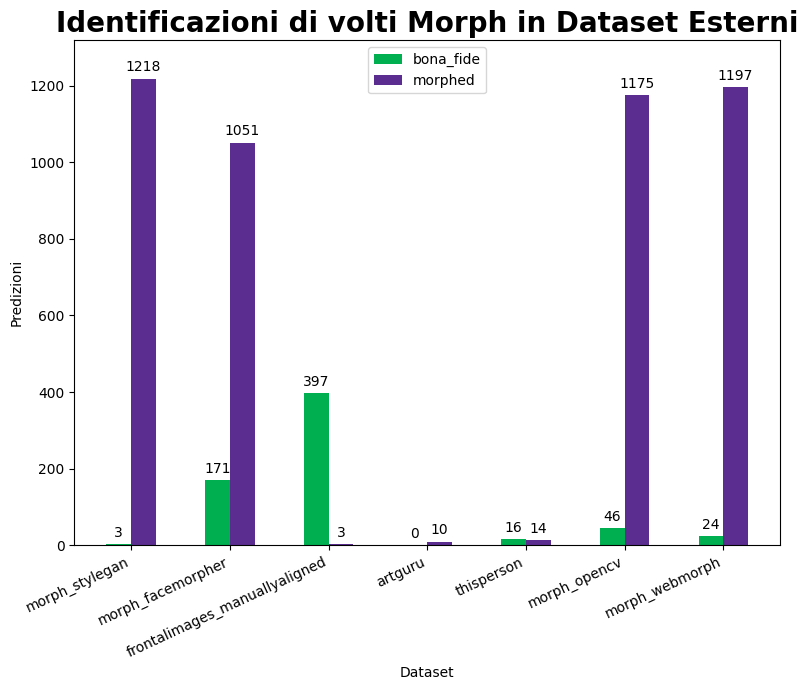

In [ ]:
create_combined_bar_chart(dict_predictions)

Stampa risultati classificazione in termini di percentuali

In [ ]:
print_percents(dict_predictions)

morph_stylegan: 99.75%
morph_facemorpher: 86.01%
frontalimages_manuallyaligned: 0.75%
artguru: 100.00%
thisperson: 46.67%
morph_opencv: 96.23%
morph_webmorph: 98.03%


Il dataset "frontalimages_manuallyaligned" ha una percentuale bassissima, ma è l'unico dataset contenente solo immagini bona_fide. Pertanto, una percentuale bassa indica delle performance altissime in quanto il modello è riuscito a classificare la maggior parte degli elementi correttamente.